In [1]:
from sklearn.utils import shuffle
from skimage.filters import threshold_multiotsu
from math import ceil
import matplotlib.pyplot as plt 
import numpy as np
import os
import cv2
import random
import torch

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import backend as k


from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
print(tf.__version__)

2.13.0


# I. Classification

In [4]:
folder_train = r"C:/Plant/Plants_2/train/"
class_folders_train = sorted(os.listdir(folder_train))
class_folders_train

['Alstonia Scholaris diseased (P2a)',
 'Alstonia Scholaris healthy (P2b)',
 'Arjun diseased (P1a)',
 'Arjun healthy (P1b)',
 'Bael diseased (P4b)',
 'Basil healthy (P8)',
 'Chinar diseased (P11b)',
 'Chinar healthy (P11a)',
 'Gauva diseased (P3b)',
 'Gauva healthy (P3a)',
 'Jamun diseased (P5b)',
 'Jamun healthy (P5a)',
 'Jatropha diseased (P6b)',
 'Jatropha healthy (P6a)',
 'Lemon diseased (P10b)',
 'Lemon healthy (P10a)',
 'Mango diseased (P0b)',
 'Mango healthy (P0a)',
 'Pomegranate diseased (P9b)',
 'Pomegranate healthy (P9a)',
 'Pongamia Pinnata diseased (P7b)',
 'Pongamia Pinnata healthy (P7a)']

In [5]:
len(class_folders_train)

22

In [6]:
label_mapping = {}
for i, class_folder in enumerate(class_folders_train):
    label_mapping[i] = class_folder
display(label_mapping)

{0: 'Alstonia Scholaris diseased (P2a)',
 1: 'Alstonia Scholaris healthy (P2b)',
 2: 'Arjun diseased (P1a)',
 3: 'Arjun healthy (P1b)',
 4: 'Bael diseased (P4b)',
 5: 'Basil healthy (P8)',
 6: 'Chinar diseased (P11b)',
 7: 'Chinar healthy (P11a)',
 8: 'Gauva diseased (P3b)',
 9: 'Gauva healthy (P3a)',
 10: 'Jamun diseased (P5b)',
 11: 'Jamun healthy (P5a)',
 12: 'Jatropha diseased (P6b)',
 13: 'Jatropha healthy (P6a)',
 14: 'Lemon diseased (P10b)',
 15: 'Lemon healthy (P10a)',
 16: 'Mango diseased (P0b)',
 17: 'Mango healthy (P0a)',
 18: 'Pomegranate diseased (P9b)',
 19: 'Pomegranate healthy (P9a)',
 20: 'Pongamia Pinnata diseased (P7b)',
 21: 'Pongamia Pinnata healthy (P7a)'}

In [7]:
visualized_data = []
for i in range(len(class_folders_train)):
    image_name = random.choice(os.listdir(folder_train + class_folders_train[i]))
    image = cv2.imread(os.path.join(folder_train, class_folders_train[i], image_name))
    visualized_data.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

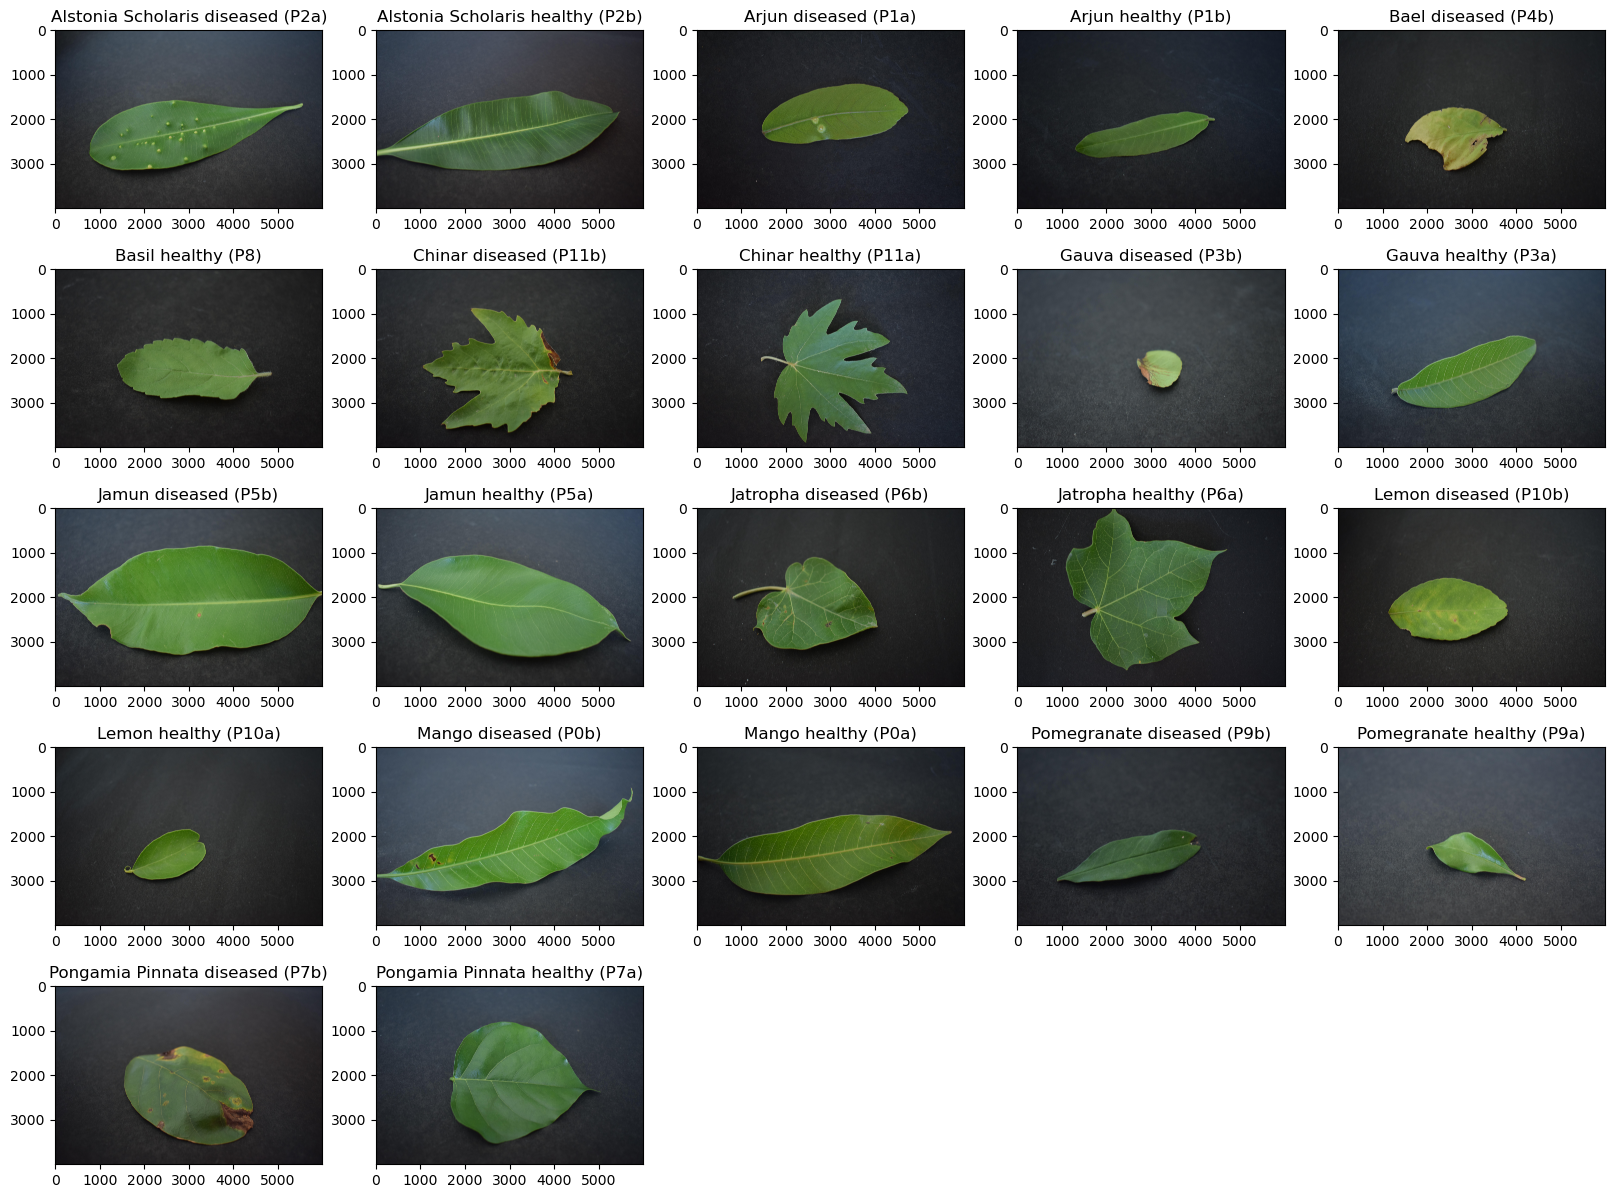

In [8]:
fig = plt.figure(figsize=(20, 15))
columns = 5
rows = 5
for i in range(1, columns*rows):
    if (i < len(visualized_data)+1):
        image = visualized_data[i-1]
        fig.add_subplot(rows, columns, i)
        plt.title(label_mapping[i-1])
        plt.imshow(image)
plt.show()

In [9]:
plant_species = []
for i in range(len(class_folders_train)):
    class_i = class_folders_train[i].split(' ')[:-2]
    if (len(class_i) == 2):
        class_i = class_i[0] + ' ' + class_i[1]
    else:
        class_i = class_i[0]
    if(class_i not in plant_species and class_i not in ['Bael','Basil']): 
        plant_species.append(class_i)
plant_species

['Alstonia Scholaris',
 'Arjun',
 'Chinar',
 'Gauva',
 'Jamun',
 'Jatropha',
 'Lemon',
 'Mango',
 'Pomegranate',
 'Pongamia Pinnata']

In [10]:
class_folders_train_temp = [x for x in class_folders_train if x not in ['Bael diseased (P4b)', 'Basil healthy (P8)']]

In [11]:
diseased  = []
healthy  = []
for i in range(len(class_folders_train_temp)):
    class_i = class_folders_train_temp[i]
    num_class_i = len(os.listdir(folder_train + class_i))
    if (i % 2 == 0):
        diseased.append(num_class_i)
    else:
        healthy.append(num_class_i)
        
print(diseased)
print(healthy)

[244, 222, 110, 131, 335, 114, 67, 255, 261, 265]
[168, 210, 93, 267, 268, 123, 149, 159, 277, 312]


In [12]:
plant_species.append('Basil')
healthy.append(len(os.listdir(folder_train + 'Basil healthy (P8)')))
diseased.append(0)

plant_species.append('Bael')
healthy.append(0)
diseased.append(len(os.listdir(folder_train + 'Bael diseased (P4b)')))

In [13]:
print(len(plant_species))
print(len(diseased))

12
12


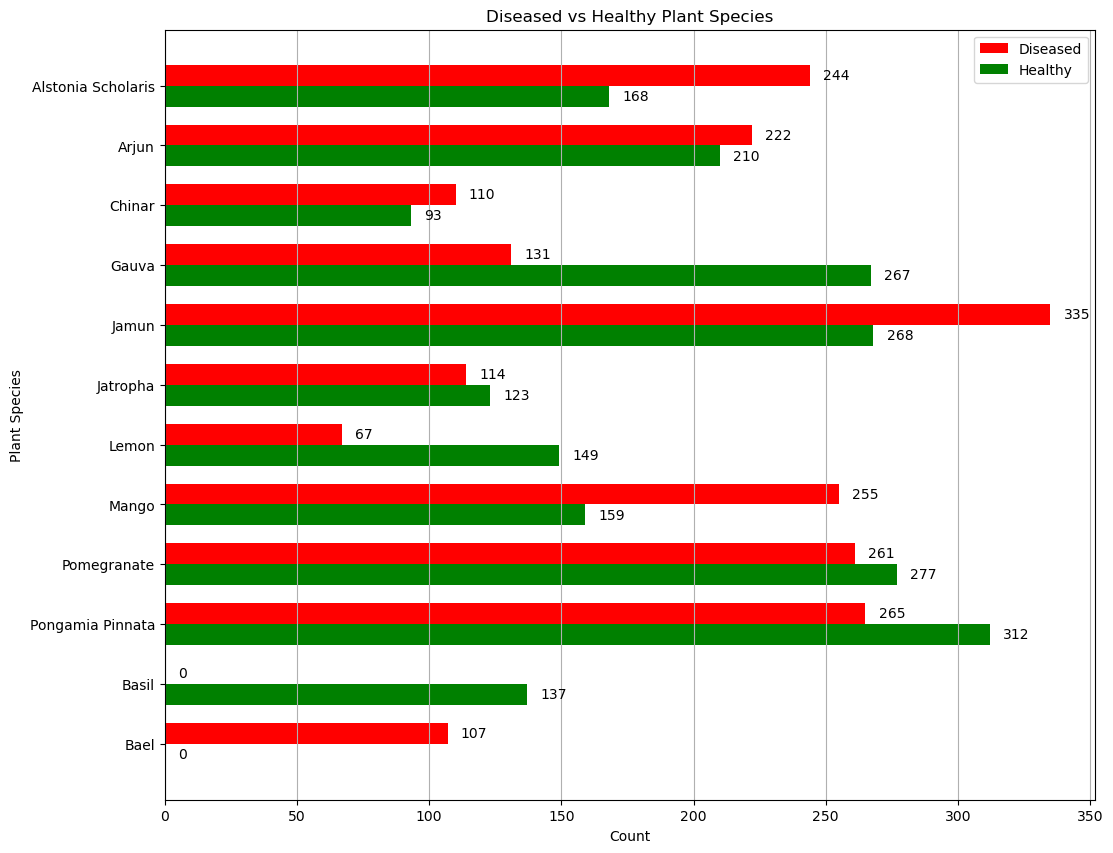

In [14]:
fig, ax = plt.subplots(figsize=(12,10))


# Set the positions of the bars on the y-axis
y = np.arange(len(plant_species))

# Set the height of the bars
bar_height = 0.35

# Plotting the bars
plt.barh(y - bar_height/2, diseased, height=bar_height, align='center', label='Diseased', color='red')
plt.barh(y + bar_height/2, healthy, height=bar_height, align='center', label='Healthy', color='green')

# Add count labels to each bar
label_offset = 5  # Adjust the offset as per your preference
for i, j in zip(y, diseased):
    plt.text(j + label_offset, i - bar_height/2, str(j), ha='left', va='center', color='black')

for i, j in zip(y, healthy):
    plt.text(j + label_offset, i + bar_height/2, str(j), ha='left', va='center', color='black')

# Add labels and title
plt.xlabel('Count')
plt.ylabel('Plant Species')
plt.title('Diseased vs Healthy Plant Species')

# Set y-tick positions and labels
plt.yticks(y, plant_species)

# Reverse the y-axis to display the plant species names from top to bottom
plt.gca().invert_yaxis()

# Add x-grid only
plt.grid(axis='x')

# Add legend
plt.legend()

# Display the chart
plt.show()


In [15]:
train_datagen = ImageDataGenerator(rescale=1./255)

# Data flow
train_generator = train_datagen.flow_from_directory(
    directory="C:/Plant/Plants_2/train/",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 4274 images belonging to 22 classes.


In [16]:
valid_datagen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_datagen.flow_from_directory(
    directory="C:/Plant/Plants_2/valid/",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 110 images belonging to 22 classes.


In [17]:
test_generator = valid_datagen.flow_from_directory(
    directory="C:/Plant/Plants_2/test/",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

Found 110 images belonging to 22 classes.


In [18]:
# Load the VGG19 model without the top (fully connected) layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False
num_classes = len(class_folders_train)
# Build the model on top of the frozen VGG19 base
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [19]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
# Define the paths for saving the best model and early stopping criteria
best_model_path = 'best_model.h5'
early_stopping_patience = 20

# Create the ModelCheckpoint callback to save the best model
checkpoint_callback = ModelCheckpoint(
    best_model_path,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=2
)

# Create the EarlyStopping callback to stop training early
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=early_stopping_patience,
    verbose=2
)

# Train the model
model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    callbacks=[checkpoint_callback, early_stopping_callback]
)

Epoch 1/50
134/134 [==============================] - ETA: 0s - loss: 1.7980 - accuracy: 0.5260
Epoch 1: val_loss improved from inf to 1.29735, saving model to best_model.h5
134/134 [==============================] - 641s 5s/step - loss: 1.7980 - accuracy: 0.5260 - val_loss: 1.2973 - val_accuracy: 0.5455
Epoch 2/50


C:\Users\Admin\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


134/134 [==============================] - ETA: 0s - loss: 0.7698 - accuracy: 0.7534
Epoch 2: val_loss improved from 1.29735 to 0.93141, saving model to best_model.h5
134/134 [==============================] - 645s 5s/step - loss: 0.7698 - accuracy: 0.7534 - val_loss: 0.9314 - val_accuracy: 0.6545
Epoch 3/50
134/134 [==============================] - ETA: 0s - loss: 0.4949 - accuracy: 0.8458
Epoch 3: val_loss improved from 0.93141 to 0.91962, saving model to best_model.h5
134/134 [==============================] - 654s 5s/step - loss: 0.4949 - accuracy: 0.8458 - val_loss: 0.9196 - val_accuracy: 0.6727
Epoch 4/50
134/134 [==============================] - ETA: 0s - loss: 0.3675 - accuracy: 0.8900
Epoch 4: val_loss improved from 0.91962 to 0.76814, saving model to best_model.h5
134/134 [==============================] - 645s 5s/step - loss: 0.3675 - accuracy: 0.8900 - val_loss: 0.7681 - val_accuracy: 0.7273
Epoch 5/50
134/134 [==============================] - ETA: 0s - loss: 0.2744 - ac

In [23]:
## Load the best model
print("best model: ")
model.load_weights("best_model.h5")

# Evaluate the model on the valid set
valid_loss, valid_accuracy = model.evaluate(valid_generator, steps=len(valid_generator))
print("Valid Loss:", valid_loss)
print("Valid Accuracy:", valid_accuracy)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

best model: 
4/4 [==============================] - 16s 4s/step - loss: 0.6710 - accuracy: 0.7636
Valid Loss: 0.671012818813324
Valid Accuracy: 0.7636363506317139
4/4 [==============================] - 17s 4s/step - loss: 0.6784 - accuracy: 0.7455
Test Loss: 0.6784456968307495
Test Accuracy: 0.7454545497894287


In [24]:
# Get the model's predictions on the test set
y_pred_prob = model.predict(test_generator)

4/4 [==============================] - 17s 4s/step


In [25]:
# Convert predictions and actual labels to binary format (0 or 1) for multiclass classification
y_pred = y_pred_prob.argmax(axis=1)
print(y_pred)
y_true = test_generator.classes
print(y_true)

[ 1  0  0  1  0  1  1  1  2  1  3  2  2  2  2 17 19  3  3  3  4  4  4  4
  4 20  5  5  5  5  6  6  6  6  6  7  7  7  7  6  8 16  8 14  8  9  9  9
  9  9 10 10 11 10 10 10 10 11 10  9 12 13 12 13 12 13 13 13 13 13 14 10
 15 14 15 15 15 15 14 14 17 16 16  1 16 17 17 17 17 17 18 18 19 18 18  3
 18 18 19 19 20 20 20 20 20 21 21 21 21 21]
[ 0  0  0  0  0  1  1  1  1  1  2  2  2  2  2  3  3  3  3  3  4  4  4  4
  4  5  5  5  5  5  6  6  6  6  6  7  7  7  7  7  8  8  8  8  8  9  9  9
  9  9 10 10 10 10 10 11 11 11 11 11 12 12 12 12 12 13 13 13 13 13 14 14
 14 14 14 15 15 15 15 15 16 16 16 16 16 17 17 17 17 17 18 18 18 18 18 19
 19 19 19 19 20 20 20 20 20 21 21 21 21 21]


F1 score on the test set: 0.7376


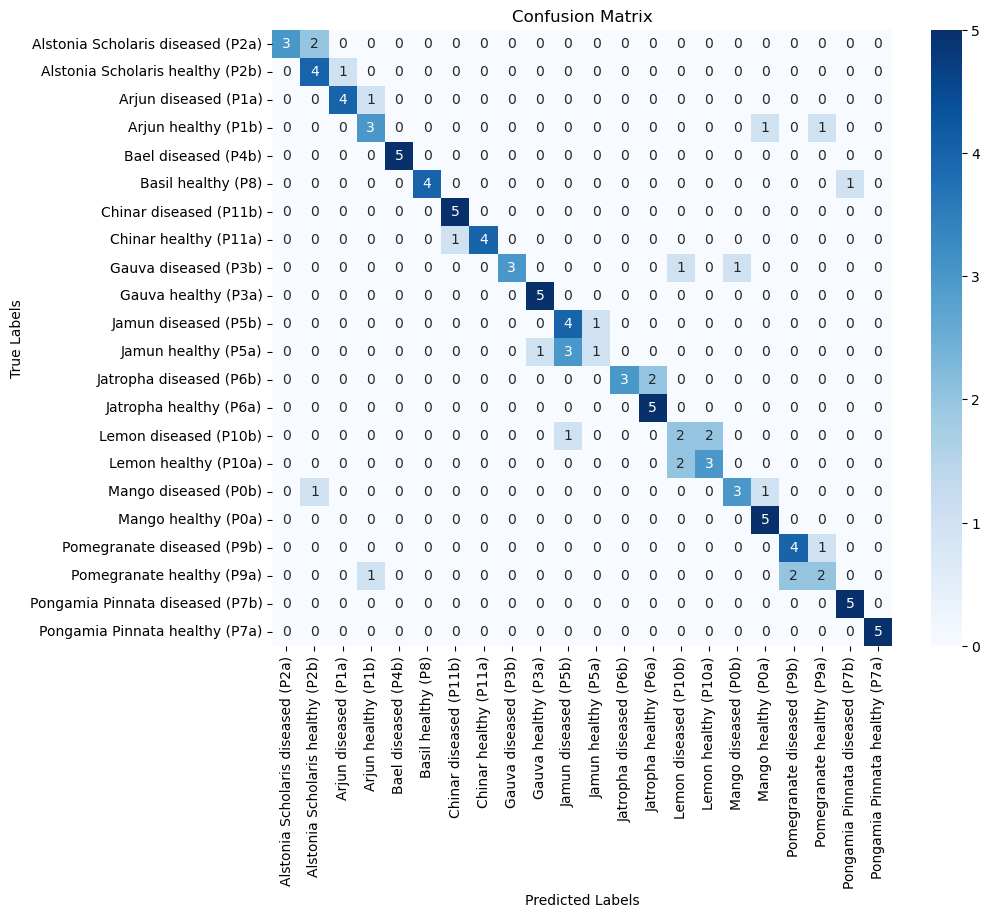

In [26]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the F1 score
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"F1 score on the test set: {f1:.4f}")

num_classes = len(class_folders_train)
confusion = confusion_matrix(y_true, y_pred, labels=range(num_classes))

plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=class_folders_train, yticklabels=class_folders_train)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [27]:
test_path = r"C:/Plant/Plants_2/images to predict/"

In [28]:
# Function to load and preprocess the image
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    img = cv2.resize(img, (224, 224))  
    img_array = img.astype(np.float32) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

In [29]:
# Function to get the predicted class label
def get_predicted_class_label(predictions, class_labels):
    predicted_class_index = np.argmax(predictions)
    predicted_class_label = class_labels[predicted_class_index]
    return predicted_class_label

1/1 [==============================] - 0s 78ms/step


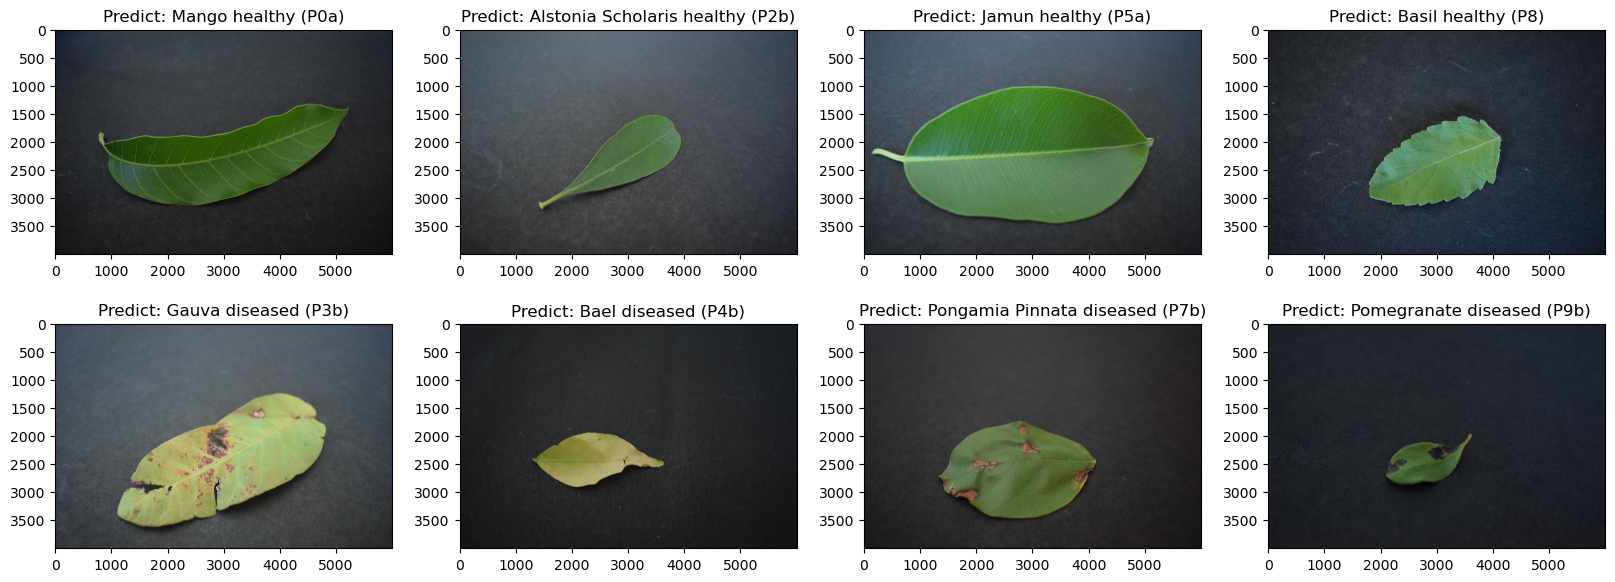

In [30]:
fig = plt.figure(figsize=(20, 7))
columns = 4
rows = 2

list_image_test = os.listdir(test_path)
image_diseased = []
plant_diseased = []

for i in range(len(list_image_test)):
    img_array = load_and_preprocess_image(test_path + list_image_test[i])
    # Make the prediction
    predictions = model.predict(img_array)
    # Get the predicted class label
    predicted_class = get_predicted_class_label(predictions, label_mapping)
    if('diseased' in predicted_class):
        image_diseased.append(list_image_test[i])
        plant_diseased.append(predicted_class)
    fig.add_subplot(rows, columns, i+1)
    plt.title('Predict: ' + predicted_class)
    plt.imshow(cv2.cvtColor(cv2.imread(test_path + list_image_test[i]), cv2.COLOR_BGR2RGB))
plt.show()

# II. Defect detection

In [31]:
print(image_diseased)

['0015_0123.JPG', '0016_0118.JPG', '0019_0276.JPG', '0020_0271.JPG']


In [32]:
pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to c:\users\admin\appdata\local\temp\pip-req-build-sjsxjq5h
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git 'C:\Users\Admin\AppData\Local\Temp\pip-req-build-sjsxjq5h'

[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [33]:
from segment_anything import SamPredictor, sam_model_registry
sam = sam_model_registry["vit_b"](checkpoint="C:\Plant\Plants_2\sam_vit_b_01ec64.pth")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sam.to(device=device)
predictor = SamPredictor(sam)

In [34]:
def find_box_input(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    img_gray = cv2.GaussianBlur(img_gray,(15,15),0)
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(2, 2))
    img_gray = clahe.apply(img_gray)
        
    blur = cv2.GaussianBlur(img_gray,(15,15),0)
    
    thresholds = threshold_multiotsu(blur)
    regions = np.digitize(img_gray, bins=thresholds)
    desired_label = 2
    region_mask = np.uint8(regions == desired_label)

    contours, hierarchy = cv2.findContours(region_mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE) 
    c = max(contours, key = cv2.contourArea)
    x,y,w,h = cv2.boundingRect(c)

    x_min, y_min = x, y
    x_max, y_max = x+w, y+h
    
    return x_min, y_min, x_max, y_max

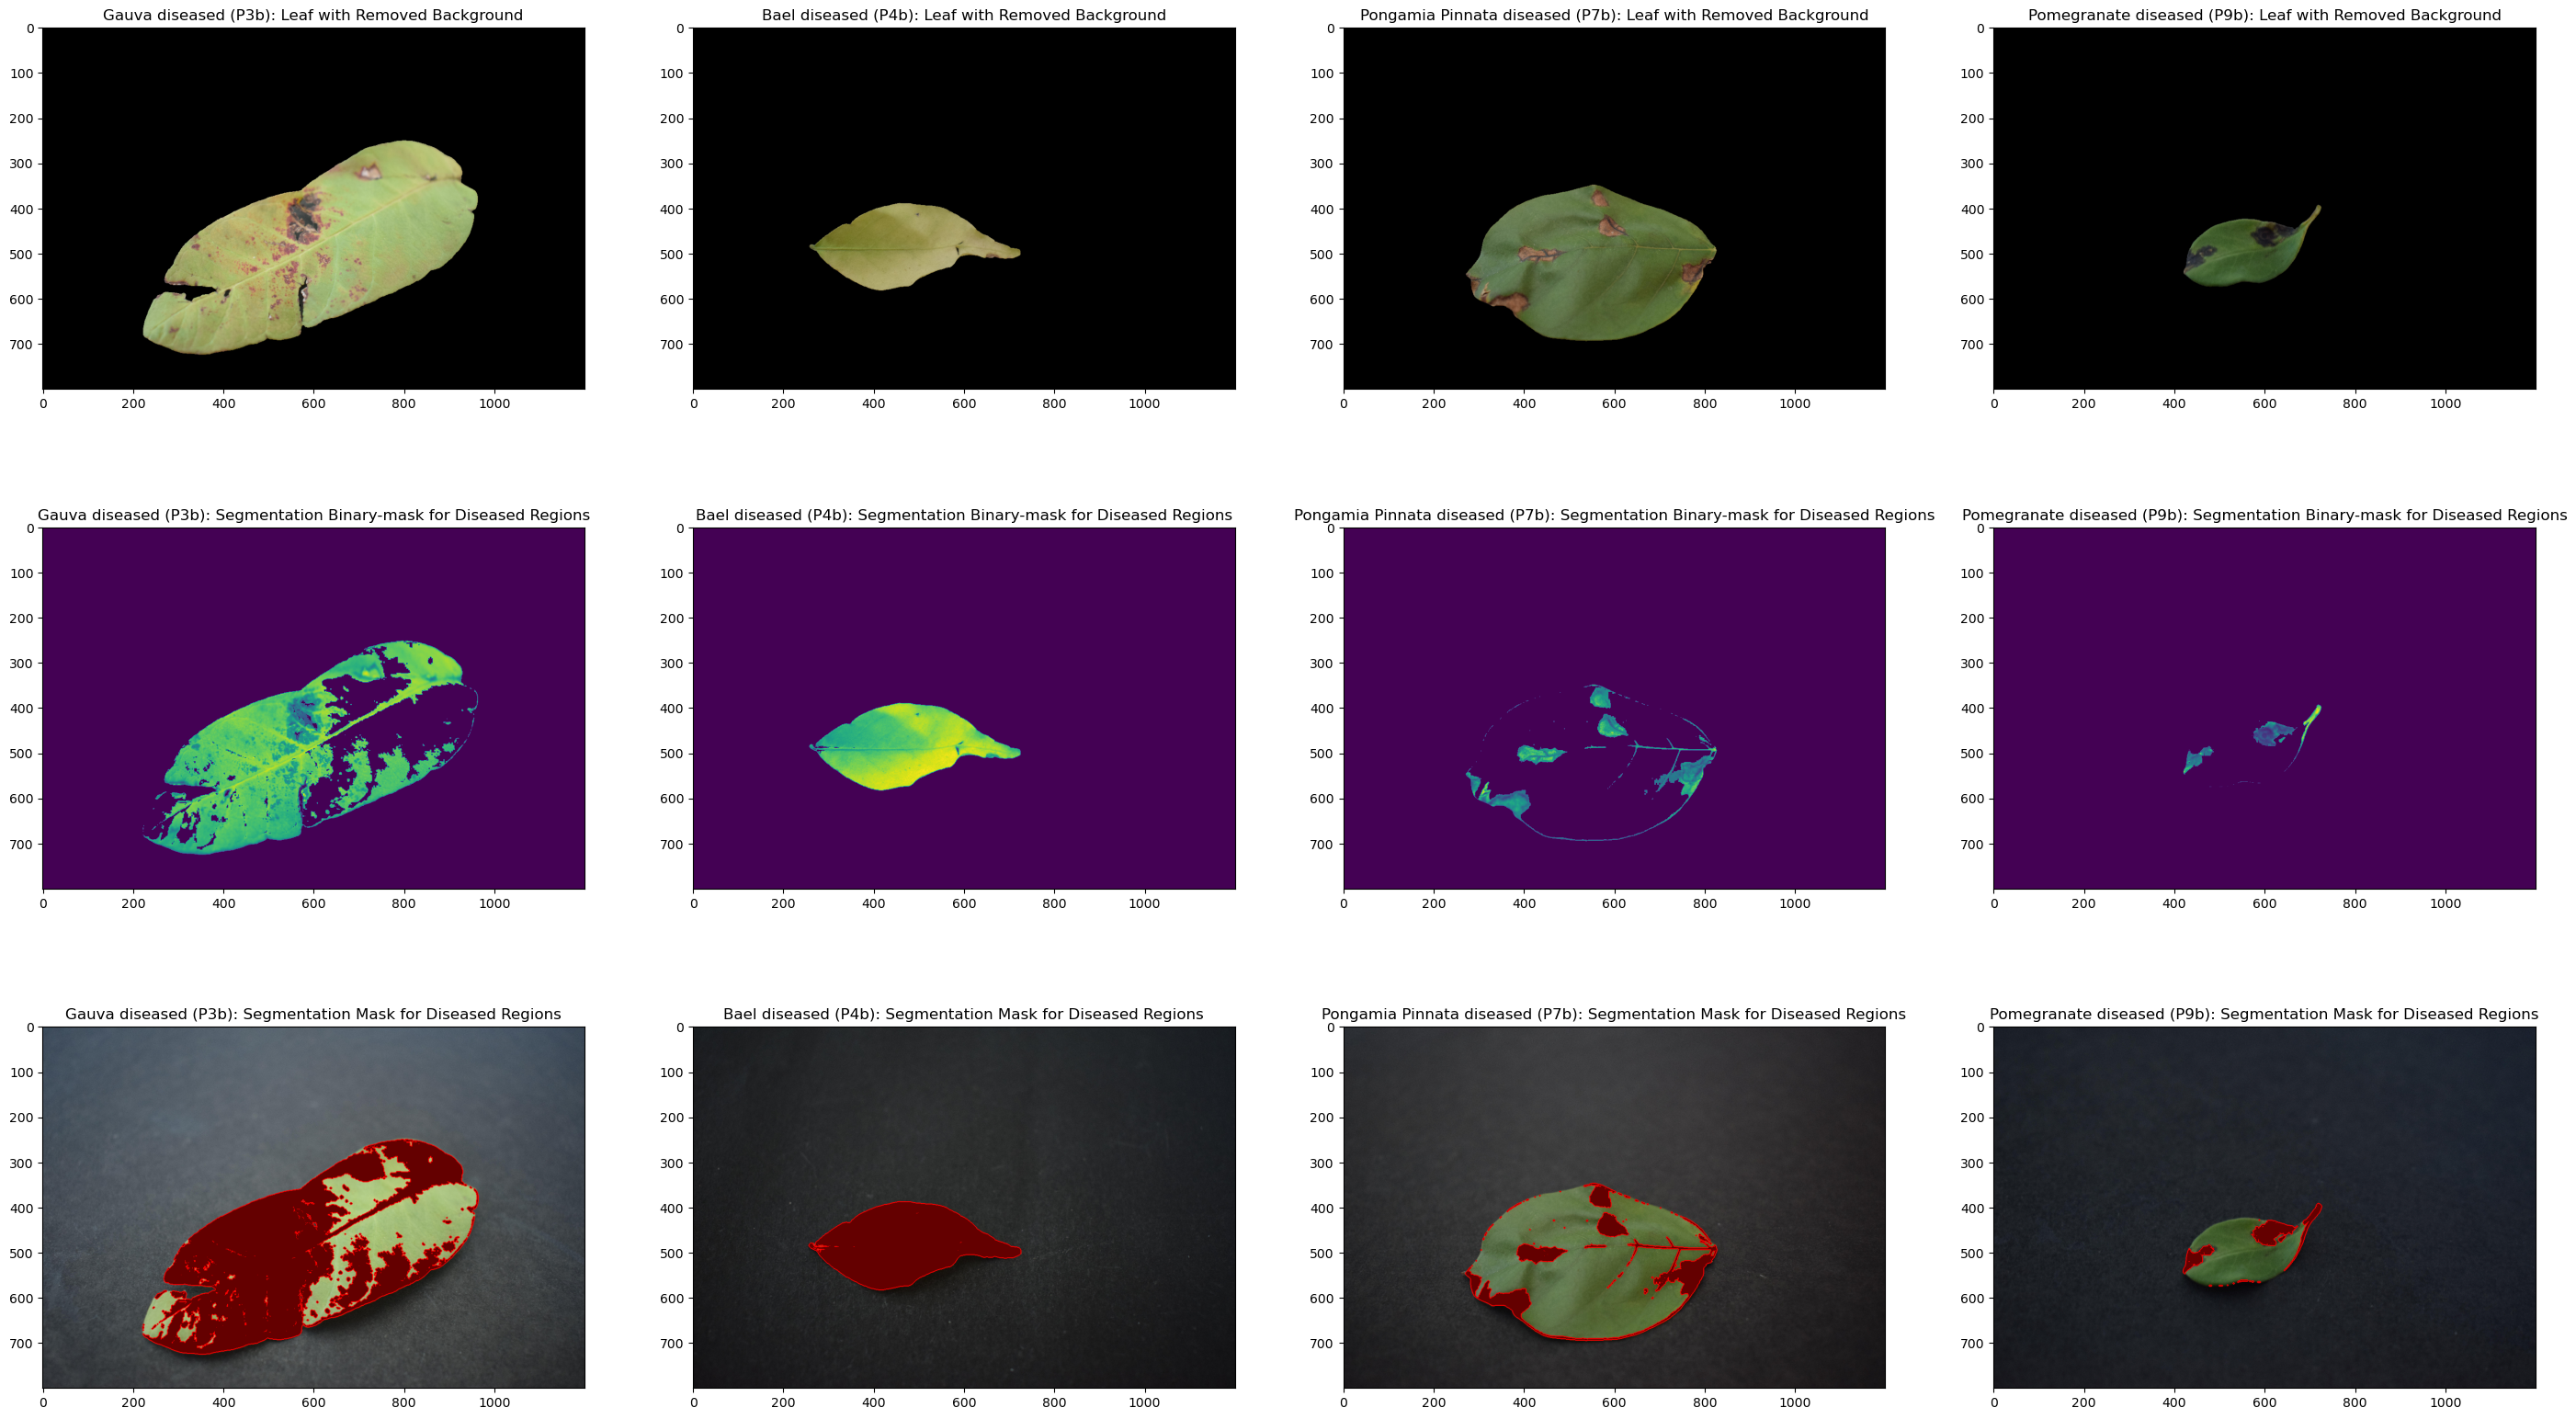

In [35]:
fig = plt.figure(figsize=(35, 20))
columns = 4
rows = 3

for i in range(len(image_diseased)):
    img = cv2.imread(test_path + image_diseased[i])
    img_resize = cv2.cvtColor(cv2.resize(img, None, fx = 0.2, fy = 0.2), cv2.COLOR_BGR2RGB)
    x_min, y_min, x_max, y_max = find_box_input(img_resize)

    predictor.set_image(img_resize)
    input_box = np.array([x_min, y_min, x_max, y_max])

    mask, scores, logits = predictor.predict(
        box=input_box,
        multimask_output=False)
    mask = np.squeeze(mask)

    mask = mask > 0
    # Apply the mask to the image
    masked_image = np.where(mask[..., np.newaxis], img_resize, 0)
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(masked_image)
    plt.title(plant_diseased[i] + ': ' + 'Leaf with Removed Background')

    # Convert the image to the HSV color space
    hsv_masked_image = cv2.cvtColor(masked_image, cv2.COLOR_RGB2HSV)

    # mask of green (36,0,0) ~ (70, 255,255)
    in_range_mask = cv2.inRange(hsv_masked_image, (36, 0, 0), (70, 255, 255))

    # Invert the mask to represent values outside the green range
    inverse_mask = cv2.bitwise_not(in_range_mask) # include the background

    # Apply the background mask to the original image to exclude the background
    result = cv2.bitwise_and(masked_image, masked_image, mask=inverse_mask)
    result_mask = cv2.cvtColor(result, cv2.COLOR_RGB2GRAY)
    fig.add_subplot(rows, columns, i+5)
    plt.imshow(result_mask)
    plt.title(plant_diseased[i] + ': ' + 'Segmentation Binary-mask for Diseased Regions')
    
    contours, hierarchy = cv2.findContours(result_mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE) 
    image_tmp = img_resize.copy()
    cv2.drawContours(image_tmp, contours, -1, (255, 0, 0), 3)
    cv2.fillPoly(image_tmp, pts=contours, color =(100,0,0))
    fig.add_subplot(rows, columns, i+9)
    plt.title(plant_diseased[i] + ': ' + 'Segmentation Mask for Diseased Regions')
    plt.imshow(image_tmp)